<a href="https://colab.research.google.com/github/TalCordova/TensorFlow_Course/blob/main/04_transfer_learning_with_tensorflow_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer Learning with TensoeFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There can be two main benefits:
  1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
  2. Can leverage a working neural network architecture whicj has already leraned patterns on similar data to our own, then can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Tue Nov 15 07:16:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close

--2022-11-15 07:16:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  15.4MB/s    in 12s     

2022-11-15 07:16:54 (13.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [ ]:
# How many images on each folder?
import os


# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent

## Create data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32
EPOCHS = 5

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/225.)
test_datagen = ImageDataGenerator(rescale = 1/225.)

print("Training Images")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")

print("Test Images")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size = IMAGE_SHAPE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = "categorical")

Training Images
Found 750 images belonging to 10 classes.
Test Images
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbackas are extra functionality you can add to your models to be performed during or after trining. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint wi the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create one for each new model)
import datetime

def create_TensorBorad_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Ym%d - H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log file to : {log_dir}")
  return tensorboard_callback

## Create models using TensorFlow Hub

In the past we've used TensorFlow to create our own models from scratch.

Now we're going to do a similar proces, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained model : https://tfhub.dev/

Browsing the TesnorFlow hub page and sorting for image classification feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url, num_classes = 10):
  """
  Takes a TensorFlow Hub URL URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurins in the output layer, should be equal to number of target classes, defauls 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer with num_classes output neurons
  """

  # Download the pre-trained model and save this as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False, # freeze the already learned patterns
                                           name = "feature_extraction_layer",
                                           input_shape = IMAGE_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation = "softmax", name = "output_model")
  ])
  return model



### Creating and testing ResNet TensorFlow Hub Feature Extraction model


In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our ResNet model
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = ["accuracy"])

In [ ]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs = EPOCHS,
                 steps_per_epoch = len(train_data_10_percent),
                 validation_data = test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_TensorBorad_callback(dir_name = "tensorflow_hub",
                                                          experiment_name="resnet50V2")])

Saving TensorBoard log file to : tensorflow_hub/resnet50V2/2022m15 - H1754
Epoch 1/5
24/24 [==============================] - 31s 857ms/step - loss: 2.1584 - accuracy: 0.3693 - val_loss: 1.2309 - val_accuracy: 0.5896
Epoch 2/5
24/24 [==============================] - 18s 772ms/step - loss: 0.9959 - accuracy: 0.6853 - val_loss: 0.9034 - val_accuracy: 0.7052
Epoch 3/5
24/24 [==============================] - 18s 765ms/step - loss: 0.6926 - accuracy: 0.7680 - val_loss: 0.8270 - val_accuracy: 0.7180
Epoch 4/5
24/24 [==============================] - 18s 765ms/step - loss: 0.5373 - accuracy: 0.8187 - val_loss: 0.7602 - val_accuracy: 0.7456
Epoch 5/5
24/24 [==============================] - 18s 762ms/step - loss: 0.4385 - accuracy: 0.8627 - val_loss: 0.7675 - val_accuracy: 0.7436


Wow!

That is incredible. Our transfer model feature extractor model out performed all the previous models we build by hand substantially, in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot out loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it
# from helper import plot_loss_curves
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate plots for training and validation matrics

  Args:
    history (history) - TensorFlow hirstory object from model.fit method

  Return:
    Two plots, one for the training data, one for validation data
  """

  loss = history.history["loss"]
  accuracy  = history.history["accuracy"]
  val_loss = history.history["val_loss"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel = ("Epochs")
  plt.legend();

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel = ("Epochs")
  plt.legend();

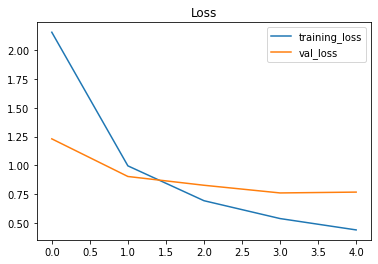

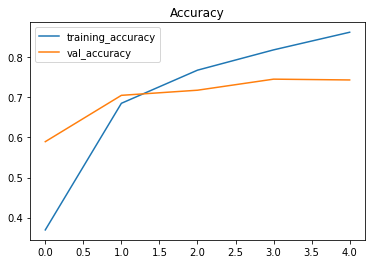

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
efficient_net = create_model(efficientnet_url,
                             num_classes = train_data_10_percent.num_classes)

# Compile EfficientNet model
efficient_net.compile(loss = "categorical_crossentropy",
                      optimizer = tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficient_net.fit(train_data_10_percent,
                  epochs = 5,
                  steps_per_epoch = len(train_data_10_percent),
                  validation_data = test_data,
                  validation_steps = len(test_data),
                  callbacks = [create_TensorBorad_callback(dir_name = "tensorflow_hub",
                                                           experiment_name = "efficientnetb0")])

Saving TensorBoard log file to : tensorflow_hub/efficientnetb0/2022m15 - H2217
Epoch 1/5
24/24 [==============================] - 33s 807ms/step - loss: 1.8236 - accuracy: 0.4320 - val_loss: 1.2988 - val_accuracy: 0.7180
Epoch 2/5
24/24 [==============================] - 18s 785ms/step - loss: 1.0765 - accuracy: 0.7667 - val_loss: 0.8828 - val_accuracy: 0.8028
Epoch 3/5
24/24 [==============================] - 21s 899ms/step - loss: 0.7735 - accuracy: 0.8387 - val_loss: 0.7198 - val_accuracy: 0.8292
Epoch 4/5
24/24 [==============================] - 19s 830ms/step - loss: 0.6214 - accuracy: 0.8627 - val_loss: 0.6321 - val_accuracy: 0.8428
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.5260 - accuracy: 0.8813 - val_loss: 0.5784 - val_accuracy: 0.8552


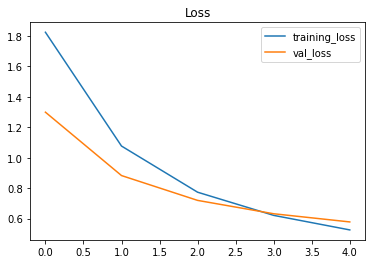

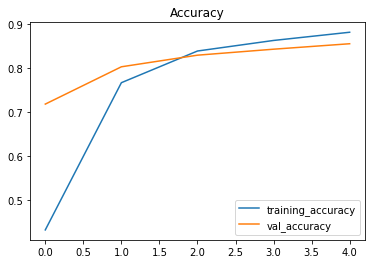

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficient_net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_model (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1001)             25615849  
 erasLayer)                                                      
                                                                 
 output_model (Dense)        (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 10,020
Non-trainable params: 25,615,849
_________________________________________________________________


In [ ]:
# How many layers does out efficientnetb0 feature extractor have?
len(efficient_net.layers[0].weights)

309

## Different types of tranfer leraning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* "**Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)


## Comapring our models results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two diffrent TF Hub feature extraction model architecture using 10% of the training data" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=d3KdhbIt6UyEuqyHtnlJOhi38YWACm&prompt=consent&access_type=off

Our TensorBoard experiments are uploaded publically here:  https://tensorboard.dev/experiment/NqC3rl2yRtyQkNGNZWTbjw/


In [ ]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/NqC3rl2yRtyQkNGNZWTbjw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diffrent TF Hub feature extraction model architecture using 10% of the training data
	Id                   NqC3rl2yRtyQkNGNZWTbjw
	Created              2022-11-15 07:35:33 (4 minutes ago)
	Updated              2022-11-15 07:35:38 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5936933
Total: 1 experiment(s)


In [ ]:
# Delete and expeirment
#!tensorboard dev delete --experiment_id NqC3rl2yRtyQkNGNZWTbjw

In [ ]:
# Confirm the deletion by rechecking what experiments you have left
!tensorboard dev list

https://tensorboard.dev/experiment/NqC3rl2yRtyQkNGNZWTbjw/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two diffrent TF Hub feature extraction model architecture using 10% of the training data
	Id                   NqC3rl2yRtyQkNGNZWTbjw
	Created              2022-11-15 07:35:33 (6 minutes ago)
	Updated              2022-11-15 07:35:38 (6 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5936933
Total: 1 experiment(s)
